In [38]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt


In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id = '1Tl8zwWg1NdRqHAjHjESIomouPRiK1_y7'
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tamil_dev.tsv')  


1Tl8zwWg1NdRqHAjHjESIomouPRiK1_y7


In [4]:
tamil_test=pd.read_csv('tamil_dev.tsv',sep='\t')
tamil_test.head()

,text,category
0,Daily likes & views pakka vanthavaga ellaruku...,Positive
1,25 k dislikes ethuku da intha trailerku poi a...,Negative
2,#Lyca unna nenacha pavama iruku ya,Mixed_feelings
3,It looks like Hindi movie amitab bachan,Positive
4,Thalaivarukku nejamavey vayasaagiduchu... siv...,Positive


In [5]:
id = '1b6o16CVjAnmZHtPz8CY0aM8beVvZBZ8T'
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tamil_train.tsv')  


1b6o16CVjAnmZHtPz8CY0aM8beVvZBZ8T


In [7]:
tamil_train=pd.read_csv('tamil_train.tsv',sep='\t')
tamil_train.head()

,text,category
0,Trailer late ah parthavanga like podunga,Positive
1,Move pathutu vanthu trailer pakurvnga yaru,Positive
2,Puthupetai dhanush ah yarellam pathinga,Positive
3,"Dhanush oda character ,puthu sa erukay , mass ta",Positive
4,vera level ippa pesungada mokka nu thalaivaaaaaa,Positive


In [10]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[Text(0, 0, 'Positive '),
 Text(0, 0, 'Negative '),
 Text(0, 0, 'Mixed_feelings '),
 Text(0, 0, 'unknown_state '),
 Text(0, 0, 'not-Tamil ')]

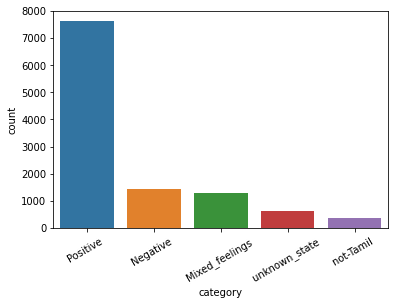

In [12]:
chart=sns.countplot(tamil_train.category)
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

[Text(0, 0, 'Positive '),
 Text(0, 0, 'Negative '),
 Text(0, 0, 'Mixed_feelings '),
 Text(0, 0, 'not-Tamil '),
 Text(0, 0, 'unknown_state ')]

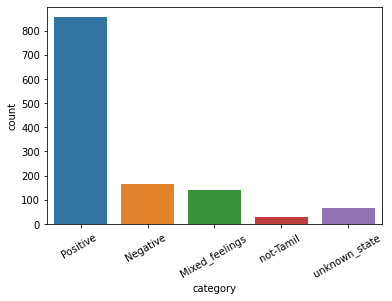

In [13]:
chart=sns.countplot(tamil_test.category)
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

In [14]:
import re
import string
import nltk
from bs4 import BeautifulSoup 

In [15]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [16]:
def strip_html(text):
  soup=BeautifulSoup(text, "html.parser")
  return soup.get_text()
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)
def remove_symbols(text):
  return re.sub('[/w]','',text)
def remove_mentio(text):
  return re.sub(r"(?:\@|https?\://)\S+", "", text)

In [17]:
def clean(text):
  text=strip_html(text)
  text=remove_mentio(text)
  text=remove_between_square_brackets(text)
  text=remove_emoji(text)
  text=remove_symbols(text)
  return text

In [18]:
tamil_train['text']=tamil_train['text'].apply(clean)
tamil_test['text']=tamil_test['text'].apply(clean)

In [19]:
x_train=tamil_train['text']
y_train=tamil_train['category']

In [20]:
x_test=tamil_test['text']
y_test=tamil_test['category']

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(x_train)

In [22]:
X_train_vect=vect.transform(x_train)
X_train_vect

<11335x19001 sparse matrix of type '<class 'numpy.int64'>'
	with 90415 stored elements in Compressed Sparse Row format>

In [23]:
max_length=192
classes=y_train.unique().tolist()


In [24]:
def trans_y(y_train):
  y_train_label=[]
  for label in y_train:
    y_train_label.append(classes.index(label))
  return y_train_label

In [25]:
y_train_label=trans_y(y_train)

In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=.1, multi_class='ovr')
model.fit(X_train_vect,y_train_label)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
y_test_label=trans_y(y_test)

In [28]:
from sklearn.metrics import roc_auc_score, accuracy_score
prediction=model.predict(vect.transform(x_test))

prediction_train=model.predict(X_train_vect)

In [29]:
accuracy_score(y_train_label,prediction_train)

0.710189677988531

In [30]:
prediction_train

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
accuracy_score(y_test_label,prediction)

0.6896825396825397

In [32]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_m=confusion_matrix(y_test_label,prediction)

confusion_df=pd.DataFrame(confusion_m,index=[i for i in range(1,6)],columns=[i for i in range(1,6)])
print(confusion_m)

[[844   7   3   2   1]
 [152  13   0   0   0]
 [135   3   0   1   2]
 [ 61   4   0   3   0]
 [ 20   0   0   0   9]]


<function matplotlib.pyplot.show>

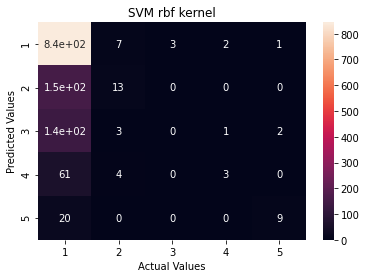

In [39]:
plt.figure
sns.heatmap(confusion_df, annot=True)
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.title('SVM rbf kernel')
plt.show

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tamil_test - tamil_test.csv to tamil_test - tamil_test.csv


In [ ]:
import io
t_test = pd.read_csv(io.BytesIO(uploaded['tamil_test - tamil_test.csv']))

In [ ]:
t_test_x=t_test['text'].apply(clean)


In [ ]:
a=model.predict(vect.transform(t_test_x))

In [ ]:
pre_m=[]
for i in a:
  pre_m.append(classes[i])

In [ ]:
t_test['label']=pre_m
t_test.head()

,id,text,label
0,ta_sent_1,Yarayellam FDFS ppga ippove ready agitinga,Positive
1,ta_sent_2,Ennada viswasam mersal sarkar madhri time la l...,Positive
2,ta_sent_3,yuvan vera level ya .... valuable script. SK i...,Positive
3,ta_sent_4,70 vayasulayum thanoda rasigargala sandhosapad...,Positive
4,ta_sent_5,all the best anna...Telugu makkal selvan fans,Positive


In [ ]:
t_test.head(50)

,id,text,label
0,ta_sent_1,Yarayellam FDFS ppga ippove ready agitinga,Positive
1,ta_sent_2,Ennada viswasam mersal sarkar madhri time la l...,Positive
2,ta_sent_3,yuvan vera level ya .... valuable script. SK i...,Positive
3,ta_sent_4,70 vayasulayum thanoda rasigargala sandhosapad...,Positive
4,ta_sent_5,all the best anna...Telugu makkal selvan fans,Positive
5,ta_sent_6,1:17 verithanama iruku nu solravanga like podunga,Positive
6,ta_sent_7,mokka ya tha iruku trailer antha level ku peru...,Positive
7,ta_sent_8,Vera level next movie Ida vida bayangaram ha i...,Positive
8,ta_sent_9,Saamy2 hindi dubbed kb la rahe ho,Positive
9,ta_sent_10,Verithanamana trailer aiyoo Diwali kaithi Diwa...,Positive


In [ ]:
t_test.to_csv('Deepesh_tamil.tsv',sep='\t')